# **3. DT**

- **Intuitive and Easy to Understand**: Decision trees are simple to interpret and visualize, as they follow a flowchart-like structure. Each internal node represents a decision based on a feature, and each leaf node represents a class label or a continuous value (for regression).

- **No Feature Scaling Required**: Unlike algorithms like KNN or SVM, decision trees do not require normalization or scaling of features, making them relatively easy to preprocess and apply.

- **Can Handle Both Categorical and Numerical Data**: Decision trees are versatile in handling different types of data, including categorical and numerical variables, making them suitable for a variety of applications.

- **Non-Linear Relationships**: Decision trees are inherently capable of modeling non-linear decision boundaries. They can divide the feature space into arbitrary regions, making them very flexible in capturing complex patterns in the data.

- **Model Interpretability**: One of the key advantages of decision trees is their **interpretability**. The tree structure itself is easy to follow, and you can clearly see how the model makes its decisions.

- **Overfitting Risk**: Decision trees are prone to overfitting, especially when they are deep (i.e., have many levels). They can create overly complex models that fit noise in the data, reducing generalization performance. This can be controlled using pruning or setting constraints (e.g., limiting the depth).

- **Pruning to Prevent Overfitting**: To prevent overfitting, decision trees can be **pruned**, which means removing branches that provide little predictive power. Pruning helps to simplify the tree and improve its ability to generalize to unseen data.

- **Handles Missing Data**: Some decision tree algorithms are capable of handling missing data by choosing the best possible split given the available data or imputing missing values based on a strategy like the most frequent class.

- **Works Well with Outliers**: Decision trees are relatively robust to outliers since they split the data into smaller regions, and extreme values might be isolated in a separate branch of the tree.

- **Can Handle Multi-class Problems**: Decision trees can naturally handle multi-class classification tasks without requiring any modification or adaptation, unlike algorithms like SVM, which may require one-vs-one or one-vs-rest approaches.

- **Feature Importance**: Decision trees automatically compute feature importance by evaluating which features contribute most to reducing uncertainty (entropy or Gini impurity). This can be used for feature selection in high-dimensional datasets.

- **Computational Complexity**:  
  - **Training**: O(n * log(n)) for small datasets, but grows more complex for large datasets, as it needs to evaluate splits for each feature and calculate metrics like entropy or Gini index.
  - **Prediction**: O(log(n)) — once the tree is built, predictions are fast, as they involve traversing the tree from the root to a leaf.

- **Sensitive to Data Distribution**: Decision trees can be biased if the data is imbalanced. If one class is overrepresented, the tree might favor that class when making splits. Techniques like class weighting or resampling can help mitigate this issue.

- **Handles Complex Interactions**: Since decision trees split data recursively on different features, they can model complex interactions between features that might be hard for linear models to capture.

- **Ensemble Methods (Random Forests and Boosting)**: Decision trees are often used as the base models in ensemble learning methods such as **Random Forests** and **Gradient Boosting**. These techniques combine multiple trees to create more robust and accurate models.

- **Training Speed**: Decision trees tend to be relatively fast to train compared to other machine learning models like neural networks or SVMs, especially for small to medium-sized datasets.

- **Non-Convex Objective**: Training a decision tree involves splitting nodes based on metrics like Gini impurity or entropy, which leads to a non-convex optimization problem. However, the greedy nature of decision tree construction makes it prone to local optima.

---

### **Advantages of Decision Trees:**
- Simple, intuitive, and easy to visualize.
- No feature scaling required.
- Can handle both numerical and categorical data.
- Can model non-linear relationships.
- Provides feature importance.
- Naturally handles multi-class problems.

### **Disadvantages of Decision Trees:**
- Prone to overfitting, especially with deep trees.
- Sensitive to small changes in data (unstable).
- Can be biased if data is imbalanced.
- Greedy nature may not always lead to the globally optimal solution.

---

### **Pruning and Regularization**:
- **Post-Pruning**: After growing a tree, branches that do not improve the model are removed.
- **Pre-Pruning**: Limiting the depth of the tree or setting a minimum number of samples required for a split can prevent overfitting during training.



## **3.1. Decision Tree Algorithm**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
from collections import Counter

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Generate synthetic 3D data (x, y, color/class)
def generate_data(n_samples=50):
    # Generate points for class 0 (clustered around (3, 3))
    class0_x = np.random.normal(3, 1.5, n_samples//2)
    class0_y = np.random.normal(3, 1.5, n_samples//2)
    class0 = np.column_stack((class0_x, class0_y, np.zeros(n_samples//2)))
    
    # Generate points for class 1 (clustered around (7, 7))
    class1_x = np.random.normal(7, 1.5, n_samples//2)
    class1_y = np.random.normal(7, 1.5, n_samples//2)
    class1 = np.column_stack((class1_x, class1_y, np.ones(n_samples//2)))
    
    # Combine the data
    data = np.vstack((class0, class1))
    
    # Shuffle the data
    np.random.shuffle(data)
    
    # Convert to integer coordinates for simplicity
    data[:, 0] = np.round(data[:, 0]).astype(int)
    data[:, 1] = np.round(data[:, 1]).astype(int)
    
    return data

# Calculate entropy for a dataset
def calculate_entropy(y):
    if len(y) == 0:
        return 0
    
    # Count the occurrences of each class
    class_counts = Counter(y)
    
    # Calculate the probabilities
    probabilities = [count / len(y) for count in class_counts.values()]
    
    # Calculate entropy: -sum(p_i * log2(p_i))
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    
    return entropy

# Calculate information gain for a split
def calculate_information_gain(data, feature_idx, threshold):
    # Get the target values
    y = data[:, 2]
    
    # Calculate the entropy of the parent node
    parent_entropy = calculate_entropy(y)
    
    # Split the data based on the threshold
    left_indices = data[:, feature_idx] <= threshold
    right_indices = ~left_indices
    
    # Get the target values for the left and right nodes
    left_y = y[left_indices]
    right_y = y[right_indices]
    
    # Calculate the weighted entropy of the children nodes
    n = len(y)
    left_weight = len(left_y) / n
    right_weight = len(right_y) / n
    
    children_entropy = (left_weight * calculate_entropy(left_y) +
                         right_weight * calculate_entropy(right_y))
    
    # Calculate the information gain
    information_gain = parent_entropy - children_entropy
    
    return information_gain, left_indices, right_indices

# Find the best split for a dataset
def find_best_split(data):
    best_gain = -1
    best_feature = -1
    best_threshold = -1
    best_left_indices = None
    best_right_indices = None
    
    # Consider each feature (x and y)
    for feature_idx in range(2):
        # Get unique values for the feature to consider as thresholds
        unique_values = np.unique(data[:, feature_idx])
        
        # Consider each possible threshold
        for i in range(len(unique_values) - 1):
            threshold = (unique_values[i] + unique_values[i + 1]) / 2
            
            # Calculate information gain for this split
            gain, left_indices, right_indices = calculate_information_gain(data, feature_idx, threshold)
            
            # Check if this split is better than the current best
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
                best_threshold = threshold
                best_left_indices = left_indices
                best_right_indices = right_indices
    
    return best_feature, best_threshold, best_gain, best_left_indices, best_right_indices

# Plot the data and the decision boundary
def plot_data_and_boundary(data, feature_idx, threshold, iteration, left_indices=None, right_indices=None):
    plt.figure(figsize=(10, 8))
    
    # Define colors for plotting
    colors = ['red', '#FFC107']  # Blue and Amber
    cmap = ListedColormap(colors)
    
    # Plot the data points
    plt.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap=cmap, s=70, edgecolors='k')
    
    # Set the axis limits
    x_min, x_max = int(data[:, 0].min()) - 1, int(data[:, 0].max()) + 1
    y_min, y_max = int(data[:, 1].min()) - 1, int(data[:, 1].max()) + 1
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Draw the decision boundary
    if feature_idx == 0:  # Split on x-axis
        plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2)
        split_text = f'X ≤ {threshold}'
    else:  # Split on y-axis
        plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2)
        split_text = f'Y ≤ {threshold}'
    
    # If we have left and right indices, highlight the regions
    if left_indices is not None and right_indices is not None:
        # Compute majority class for each region
        left_class = Counter(data[left_indices, 2]).most_common(1)[0][0] if len(data[left_indices]) > 0 else -1
        right_class = Counter(data[right_indices, 2]).most_common(1)[0][0] if len(data[right_indices]) > 0 else -1
        
        # Plot transparent colored regions for each split
        if feature_idx == 0:  # Split on x-axis
            plt.fill_betweenx(
                [y_min, y_max], x_min, threshold, 
                color=colors[int(left_class)] if left_class != -1 else 'gray', 
                alpha=0.2
            )
            plt.fill_betweenx(
                [y_min, y_max], threshold, x_max, 
                color=colors[int(right_class)] if right_class != -1 else 'gray', 
                alpha=0.2
            )
        else:  # Split on y-axis
            plt.fill_between(
                [x_min, x_max], y_min, threshold, 
                color=colors[int(left_class)] if left_class != -1 else 'gray', 
                alpha=0.2
            )
            plt.fill_between(
                [x_min, x_max], threshold, y_max, 
                color=colors[int(right_class)] if right_class != -1 else 'gray', 
                alpha=0.2
            )
    
    # Add labels and title
    plt.xlabel('X Feature')
    plt.ylabel('Y Feature')
    plt.title(f'Decision Tree Iteration {iteration}: {split_text}')
    
    # Add a legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=10, label='Class 0'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='Class 1')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Add text annotations
    if left_indices is not None and right_indices is not None:
        left_count = Counter(data[left_indices, 2]) if len(data[left_indices]) > 0 else Counter()
        right_count = Counter(data[right_indices, 2]) if len(data[right_indices]) > 0 else Counter()
        
        left_text = f'Left: {left_count.get(0.0, 0)} class 0, {left_count.get(1.0, 0)} class 1'
        right_text = f'Right: {right_count.get(0.0, 0)} class 0, {right_count.get(1.0, 0)} class 1'
        
        if feature_idx == 0:  # Split on x-axis
            plt.text((x_min + threshold) / 2, y_max - 1, left_text, ha='center')
            plt.text((threshold + x_max) / 2, y_max - 1, right_text, ha='center')
        else:  # Split on y-axis
            plt.text(x_max - 2, (y_min + threshold) / 2, left_text, va='center')
            plt.text(x_max - 2, (threshold + y_max) / 2, right_text, va='center')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Print detailed information about the split
def print_split_info(feature_idx, threshold, gain, parent_data, left_data, right_data):
    print(f"Feature: {'X' if feature_idx == 0 else 'Y'}")
    print(f"Threshold: {threshold}")
    print(f"Information Gain: {gain:.6f}")
    
    # Calculate and display entropy values
    parent_entropy = calculate_entropy(parent_data[:, 2])
    left_entropy = calculate_entropy(left_data[:, 2])
    right_entropy = calculate_entropy(right_data[:, 2])
    
    print(f"Parent Entropy: {parent_entropy:.6f}")
    print(f"Left Child Entropy: {left_entropy:.6f} (Samples: {len(left_data)})")
    print(f"Right Child Entropy: {right_entropy:.6f} (Samples: {len(right_data)})")
    
    # Calculate class counts
    parent_counts = Counter(parent_data[:, 2])
    left_counts = Counter(left_data[:, 2])
    right_counts = Counter(right_data[:, 2])
    
    print(f"Parent Class Counts: Class 0: {parent_counts.get(0.0, 0)}, Class 1: {parent_counts.get(1.0, 0)}")
    print(f"Left Class Counts: Class 0: {left_counts.get(0.0, 0)}, Class 1: {left_counts.get(1.0, 0)}")
    print(f"Right Class Counts: Class 0: {right_counts.get(0.0, 0)}, Class 1: {right_counts.get(1.0, 0)}")
    
    # Weighted entropy calculation
    n = len(parent_data)
    left_weight = len(left_data) / n
    right_weight = len(right_data) / n
    weighted_entropy = left_weight * left_entropy + right_weight * right_entropy
    print(f"Weighted Children Entropy: {weighted_entropy:.6f}")
    print(f"Verification: Parent Entropy - Weighted Children Entropy = Information Gain")
    print(f"{parent_entropy:.6f} - {weighted_entropy:.6f} = {parent_entropy - weighted_entropy:.6f}")
    print("-" * 60)

ITERATION 1: Finding the best split for the root node
Feature: X
Threshold: 5.5
Information Gain: 0.724907
Parent Entropy: 1.000000
Left Child Entropy: 0.491237 (Samples: 28)
Right Child Entropy: -0.000000 (Samples: 22)
Parent Class Counts: Class 0: 25, Class 1: 25
Left Class Counts: Class 0: 25, Class 1: 3
Right Class Counts: Class 0: 0, Class 1: 22
Weighted Children Entropy: 0.275093
Verification: Parent Entropy - Weighted Children Entropy = Information Gain
1.000000 - 0.275093 = 0.724907
------------------------------------------------------------


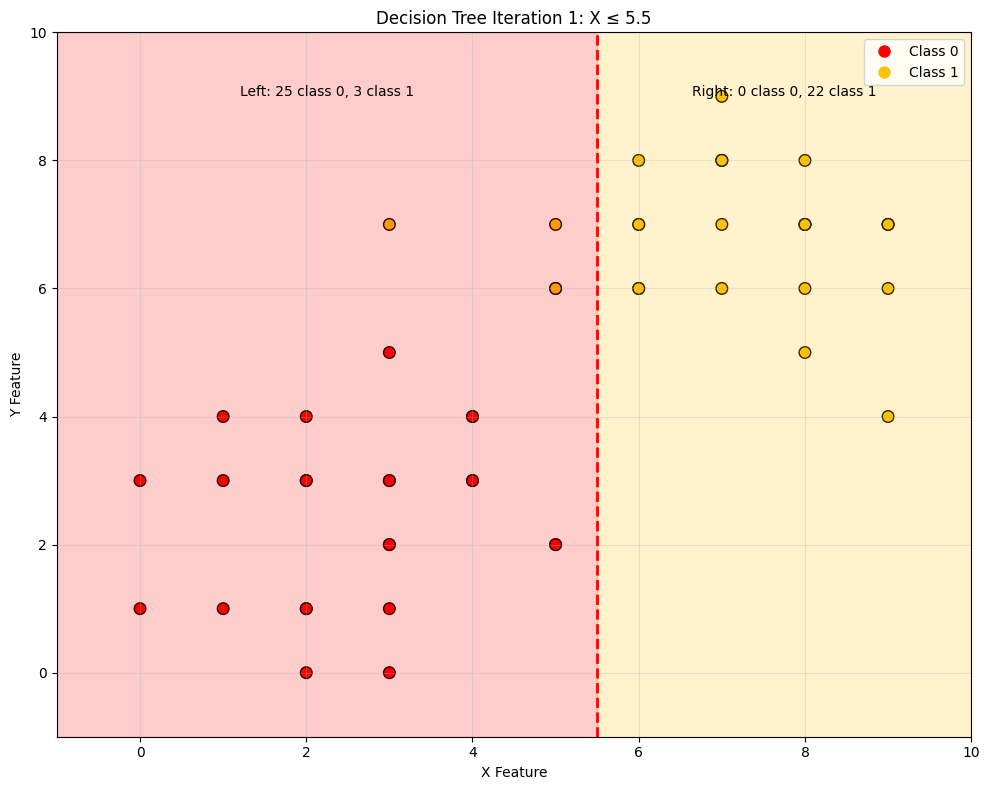

In [7]:
# ----------------------------- ITERATION 1 -----------------------------
# Generate the dataset
data = generate_data(n_samples=50)

# Find the best split for the root node
feature_idx, threshold, gain, left_indices, right_indices = find_best_split(data)

# Split the data
left_data = data[left_indices]
right_data = data[right_indices]

# Print information about the split
print("ITERATION 1: Finding the best split for the root node")
print_split_info(feature_idx, threshold, gain, data, left_data, right_data)

# Plot the data and the decision boundary
plot_data_and_boundary(data, feature_idx, threshold, 1, left_indices, right_indices)

ITERATION 2: Finding the best split for the left node
Feature: Y
Threshold: 5.5
Information Gain: 0.375340
Parent Entropy: 0.491237
Left Child Entropy: -0.000000 (Samples: 24)
Right Child Entropy: 0.811278 (Samples: 4)
Parent Class Counts: Class 0: 25, Class 1: 3
Left Class Counts: Class 0: 24, Class 1: 0
Right Class Counts: Class 0: 1, Class 1: 3
Weighted Children Entropy: 0.115897
Verification: Parent Entropy - Weighted Children Entropy = Information Gain
0.491237 - 0.115897 = 0.375340
------------------------------------------------------------


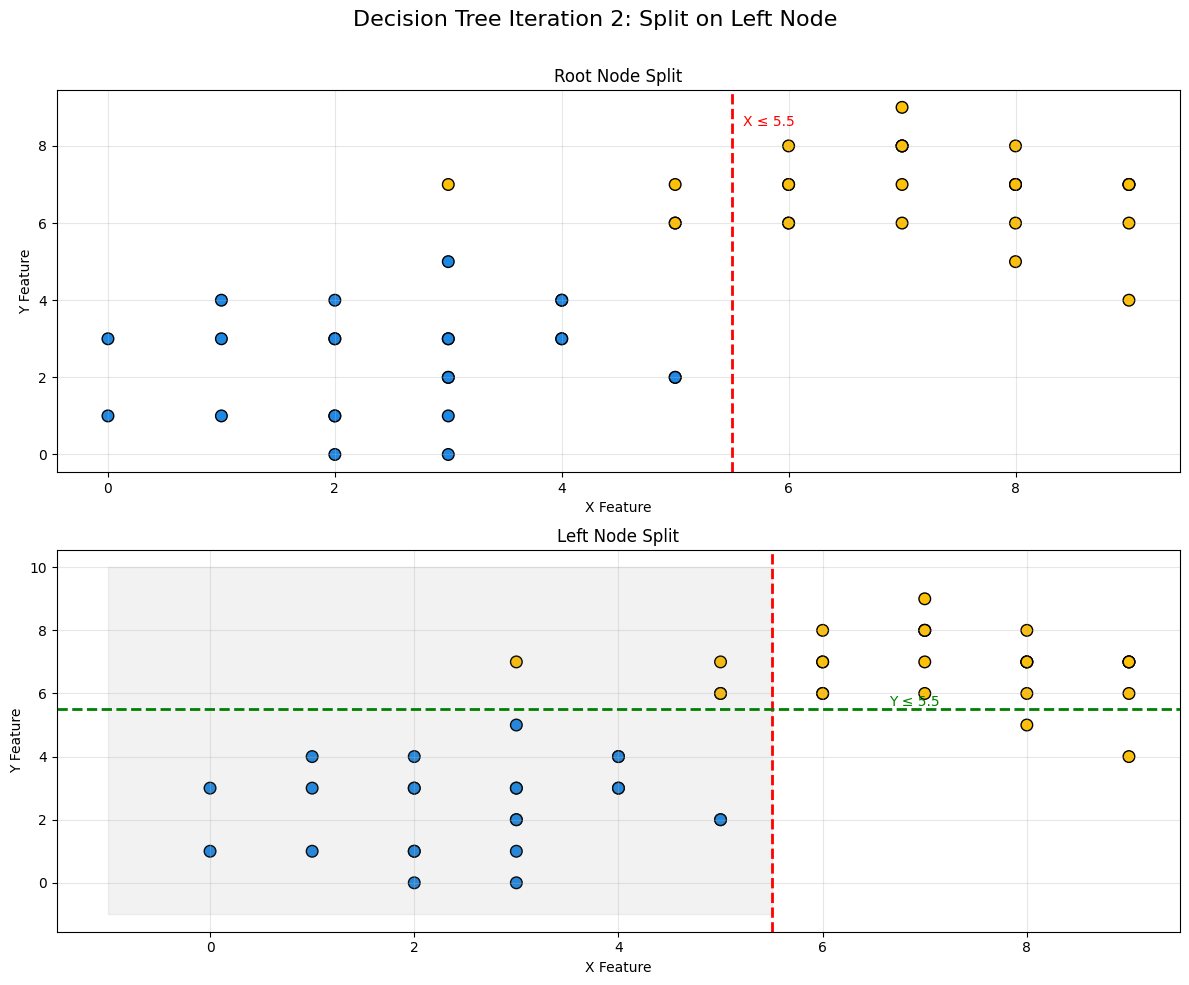

In [8]:
# ----------------------------- ITERATION 2 -----------------------------
# Continue from previous iteration
# Now, find the best split for the left node
left_feature_idx, left_threshold, left_gain, left_left_indices, left_right_indices = find_best_split(left_data)

# Adjust indices to refer to the original dataset
original_left_left_indices = np.zeros(len(data), dtype=bool)
original_left_right_indices = np.zeros(len(data), dtype=bool)

# Map the left node's split back to original data indices
original_left_left_indices[left_indices] = left_left_indices
original_left_right_indices[left_indices] = left_right_indices

# Split the left data
left_left_data = left_data[left_left_indices]
left_right_data = left_data[left_right_indices]

# Print information about the split
print("ITERATION 2: Finding the best split for the left node")
print_split_info(left_feature_idx, left_threshold, left_gain, left_data, left_left_data, left_right_data)

# Plot the data and the decision boundary for the left node
plt.figure(figsize=(12, 10))

# Main plot title and axis labels
plt.suptitle(f'Decision Tree Iteration 2: Split on Left Node', fontsize=16)
plt.subplots_adjust(top=0.9)

# First subplot: Show the original split
plt.subplot(2, 1, 1)
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap=ListedColormap(['#1E88E5', '#FFC107']), s=70, edgecolors='k')
if feature_idx == 0:  # Split on x-axis
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2)
    plt.text(threshold + 0.1, plt.ylim()[1] * 0.9, f'X ≤ {threshold}', color='red')
else:  # Split on y-axis
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2)
    plt.text(plt.xlim()[1] * 0.9, threshold + 0.1, f'Y ≤ {threshold}', color='red')

plt.title('Root Node Split')
plt.xlabel('X Feature')
plt.ylabel('Y Feature')
plt.grid(True, alpha=0.3)

# Second subplot: Show the left node split
plt.subplot(2, 1, 2)
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap=ListedColormap(['#1E88E5', '#FFC107']), s=70, edgecolors='k')

# Highlight the left region from the first split
x_min, x_max = int(data[:, 0].min()) - 1, int(data[:, 0].max()) + 1
y_min, y_max = int(data[:, 1].min()) - 1, int(data[:, 1].max()) + 1

if feature_idx == 0:  # Root split on x-axis
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2)
    plt.fill_betweenx([y_min, y_max], x_min, threshold, color='gray', alpha=0.1)
    
    # Add the left node split
    if left_feature_idx == 0:  # Left node split on x-axis
        plt.axvline(x=left_threshold, color='green', linestyle='--', linewidth=2, 
                   xmin=0, xmax=(threshold-x_min)/(x_max-x_min))
        plt.text(left_threshold + 0.1, plt.ylim()[1] * 0.8, 
                f'X ≤ {left_threshold}', color='green')
    else:  # Left node split on y-axis
        plt.axhline(y=left_threshold, color='green', linestyle='--', linewidth=2)
        plt.text(plt.xlim()[1] * 0.7, left_threshold + 0.1, 
                f'Y ≤ {left_threshold}', color='green')
else:  # Root split on y-axis
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2)
    plt.fill_between([x_min, x_max], y_min, threshold, color='gray', alpha=0.1)
    
    # Add the left node split
    if left_feature_idx == 0:  # Left node split on x-axis
        plt.axvline(x=left_threshold, color='green', linestyle='--', linewidth=2)
        plt.text(left_threshold + 0.1, plt.ylim()[1] * 0.8, 
                f'X ≤ {left_threshold}', color='green')
    else:  # Left node split on y-axis
        plt.axhline(y=left_threshold, color='green', linestyle='--', linewidth=2, 
                   ymin=0, ymax=(threshold-y_min)/(y_max-y_min))
        plt.text(plt.xlim()[1] * 0.7, left_threshold + 0.1, 
                f'Y ≤ {left_threshold}', color='green')

plt.title('Left Node Split')
plt.xlabel('X Feature')
plt.ylabel('Y Feature')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

ITERATION 3: Finding the best split for the right node
Feature: X
Threshold: 6.5
Information Gain: 0.000000
Parent Entropy: -0.000000
Left Child Entropy: -0.000000 (Samples: 5)
Right Child Entropy: -0.000000 (Samples: 17)
Parent Class Counts: Class 0: 0, Class 1: 22
Left Class Counts: Class 0: 0, Class 1: 5
Right Class Counts: Class 0: 0, Class 1: 17
Weighted Children Entropy: -0.000000
Verification: Parent Entropy - Weighted Children Entropy = Information Gain
-0.000000 - -0.000000 = 0.000000
------------------------------------------------------------


AttributeError: Line2D.set() got an unexpected keyword argument 'xmin'

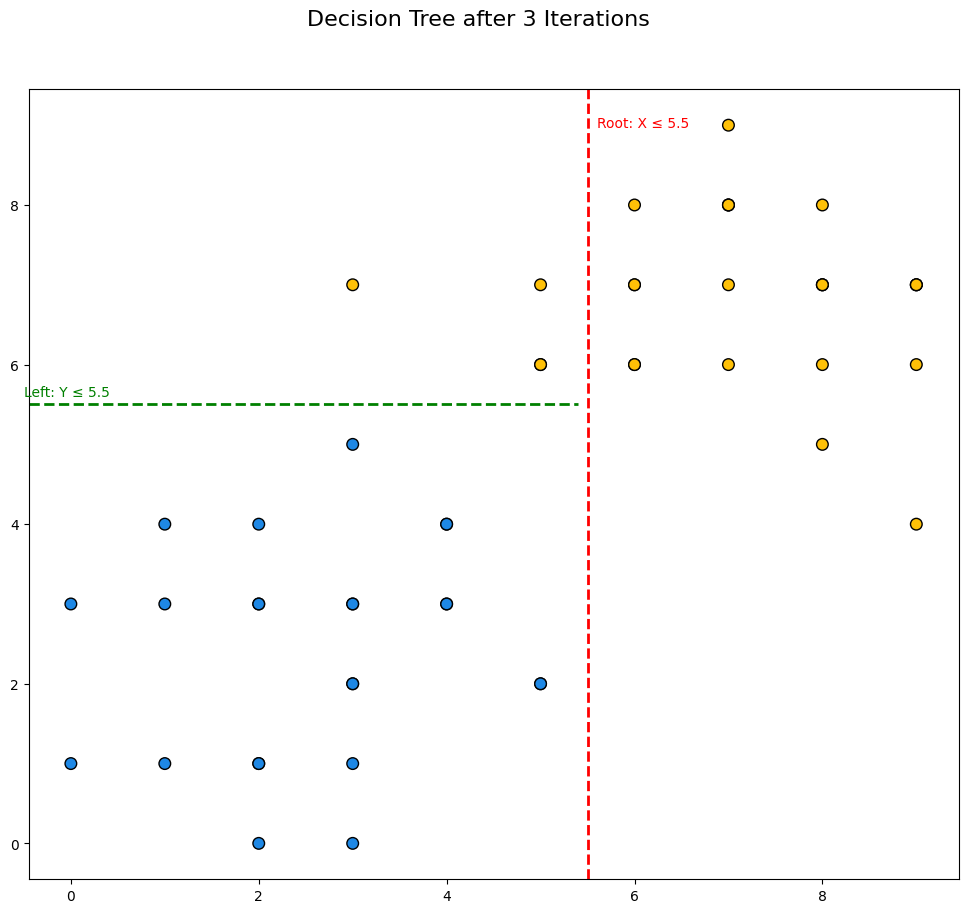

In [5]:
# ----------------------------- ITERATION 3 -----------------------------
# Continue from previous iterations
# Now, find the best split for the right node from the root
right_feature_idx, right_threshold, right_gain, right_left_indices, right_right_indices = find_best_split(right_data)

# Adjust indices to refer to the original dataset
original_right_left_indices = np.zeros(len(data), dtype=bool)
original_right_right_indices = np.zeros(len(data), dtype=bool)

# Map the right node's split back to original data indices
original_right_left_indices[right_indices] = right_left_indices
original_right_right_indices[right_indices] = right_right_indices

# Split the right data
right_left_data = right_data[right_left_indices]
right_right_data = right_data[right_right_indices]

# Print information about the split
print("ITERATION 3: Finding the best split for the right node")
print_split_info(right_feature_idx, right_threshold, right_gain, right_data, right_left_data, right_right_data)

# Plot the data and the decision boundaries for all splits so far
plt.figure(figsize=(12, 10))

# Main plot title
plt.suptitle('Decision Tree after 3 Iterations', fontsize=16)
plt.subplots_adjust(top=0.9)

# Plot the data points
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap=ListedColormap(['#1E88E5', '#FFC107']), s=70, edgecolors='k')

# Draw the root split
x_min, x_max = int(data[:, 0].min()) - 1, int(data[:, 0].max()) + 1
y_min, y_max = int(data[:, 1].min()) - 1, int(data[:, 1].max()) + 1

if feature_idx == 0:  # Root split on x-axis
    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2)
    plt.text(threshold + 0.1, plt.ylim()[1] * 0.95, f'Root: X ≤ {threshold}', color='red')
    
    # Draw the left node split
    if left_feature_idx == 0:  # Left node split on x-axis
        plt.axvline(x=left_threshold, color='green', linestyle='--', linewidth=2, 
                   xmin=0, xmax=(threshold-x_min)/(x_max-x_min))
        plt.text(left_threshold + 0.1, plt.ylim()[1] * 0.85, 
                f'Left: X ≤ {left_threshold}', color='green')
    else:  # Left node split on y-axis
        plt.axhline(y=left_threshold, color='green', linestyle='--', linewidth=2,
                   xmin=0, xmax=(threshold-x_min)/(x_max-x_min))
        plt.text(x_min + 0.5, left_threshold + 0.1, 
                f'Left: Y ≤ {left_threshold}', color='green')
    
    # Draw the right node split
    if right_feature_idx == 0:  # Right node split on x-axis
        plt.axvline(x=right_threshold, color='purple', linestyle='--', linewidth=2, 
                   xmin=(threshold-x_min)/(x_max-x_min), xmax=1)
        plt.text(right_threshold + 0.1, plt.ylim()[1] * 0.85, 
                f'Right: X ≤ {right_threshold}', color='purple')
    else:  # Right node split on y-axis
        plt.axhline(y=right_threshold, color='purple', linestyle='--', linewidth=2,
                   xmin=(threshold-x_min)/(x_max-x_min), xmax=1)
        plt.text(threshold + 0.5, right_threshold + 0.1, 
                f'Right: Y ≤ {right_threshold}', color='purple')
else:  # Root split on y-axis
    plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2)
    plt.text(plt.xlim()[1] * 0.9, threshold + 0.1, f'Root: Y ≤ {threshold}', color='red')
    
    # Draw the left node split
    if left_feature_idx == 0:  # Left node split on x-axis
        plt.axvline(x=left_threshold, color='green', linestyle='--', linewidth=2,
                   ymin=0, ymax=(threshold-y_min)/(y_max-y_min))
        plt.text(left_threshold + 0.1, y_min + 1, 
                f'Left: X ≤ {left_threshold}', color='green')
    else:  # Left node split on y-axis
        plt.axhline(y=left_threshold, color='green', linestyle='--', linewidth=2, 
                   ymin=0, ymax=(threshold-y_min)/(y_max-y_min))
        plt.text(plt.xlim()[1] * 0.8, left_threshold + 0.1, 
                f'Left: Y ≤ {left_threshold}', color='green')
    
    # Draw the right node split
    if right_feature_idx == 0:  # Right node split on x-axis
        plt.axvline(x=right_threshold, color='purple', linestyle='--', linewidth=2,
                   ymin=(threshold-y_min)/(y_max-y_min), ymax=1)
        plt.text(right_threshold + 0.1, threshold + 1, 
                f'Right: X ≤ {right_threshold}', color='purple')
    else:  # Right node split on y-axis
        plt.axhline(y=right_threshold, color='purple', linestyle='--', linewidth=2, 
                   ymin=(threshold-y_min)/(y_max-y_min), ymax=1)
        plt.text(plt.xlim()[1] * 0.8, right_threshold + 0.1, 
                f'Right: Y ≤ {right_threshold}', color='purple')

# Add a simplified decision tree visualization as an inset
left_ax = plt.axes([0.15, 0.15, 0.3, 0.2])
left_ax.axis('off')
# Draw the tree structure
node_style = dict(boxstyle="round", fc="white", ec="black")
leaf_style = dict(boxstyle="round", fc="lightgray", ec="black")

# Root node
left_ax.text(0.5, 0.9, f"Root\n{'X' if feature_idx == 0 else 'Y'} ≤ {threshold}", 
        ha="center", va="center", size=10, bbox=node_style)

# Left child
left_ax.text(0.25, 0.5, f"Left\n{'X' if left_feature_idx == 0 else 'Y'} ≤ {left_threshold}", 
        ha="center", va="center", size=9, bbox=node_style)

# Right child
left_ax.text(0.75, 0.5, f"Right\n{'X' if right_feature_idx == 0 else 'Y'} ≤ {right_threshold}", 
        ha="center", va="center", size=9, bbox=node_style)

# Connect nodes with arrows
left_ax.annotate("", xy=(0.25, 0.5), xytext=(0.5, 0.9), 
              arrowprops=dict(arrowstyle="->"))
left_ax.annotate("", xy=(0.75, 0.5), xytext=(0.5, 0.9), 
              arrowprops=dict(arrowstyle="->"))

# Leaf nodes for left split
left_ax.text(0.15, 0.1, f"Leaf\nClass {int(Counter(left_left_data[:, 2]).most_common(1)[0][0])}", 
        ha="center", va="center", size=8, bbox=leaf_style)
left_ax.text(0.35, 0.1, f"Leaf\nClass {int(Counter(left_right_data[:, 2]).most_common(1)[0][0])}", 
        ha="center", va="center", size=8, bbox=leaf_style)

# Leaf nodes for right split
left_ax.text(0.65, 0.1, f"Leaf\nClass {int(Counter(right_left_data[:, 2]).most_common(1)[0][0])}", 
        ha="center", va="center", size=8, bbox=leaf_style)
left_ax.text(0.85, 0.1, f"Leaf\nClass {int(Counter(right_right_data[:, 2]).most_common(1)[0][0])}", 
        ha="center", va="center", size=8, bbox=leaf_style)

# Connect leaf nodes with arrows
left_ax.annotate("", xy=(0.15, 0.1), xytext=(0.25, 0.5), 
              arrowprops=dict(arrowstyle="->"))
left_ax.annotate("", xy=(0.35, 0.1), xytext=(0.25, 0.5), 
              arrowprops=dict(arrowstyle="->"))
left_ax.annotate("", xy=(0.65, 0.1), xytext=(0.75, 0.5), 
              arrowprops=dict(arrowstyle="->"))
left_ax.annotate("", xy=(0.85, 0.1), xytext=(0.75, 0.5), 
              arrowprops=dict(arrowstyle="->"))

# Main plot formatting
plt.xlabel('X Feature')
plt.ylabel('Y Feature')
plt.title('Decision Boundaries After 3 Splits')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Final visualization - Draw regions with predicted classes
plt.figure(figsize=(10, 8))

# Create a mesh grid for visualization
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                     np.arange(y_min, y_max, 0.5))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Function to predict class based on our simple decision tree
def predict_class(x, y):
    # Root split
    if feature_idx == 0:  # x-axis split
        if x <= threshold:  # Go left
            if left_feature_idx == 0:  # x-axis split
                return 0 if x <= left_threshold else 1
            else:  # y-axis split
                return 0 if y <= left_threshold else 1
        else:  # Go right
            if right_feature_idx == 0:  # x-axis split
                return 0 if x <= right_threshold else 1
            else:  # y-axis split
                return 0 if y <= right_threshold else 1
    else:  # y-axis split
        if y <= threshold:  # Go left
            if left_feature_idx == 0:  # x-axis split
                return 0 if x <= left_threshold else 1
            else:  # y-axis split
                return 0 if y <= left_threshold else 1
        else:  # Go right
            if right_feature_idx == 0:  # x-axis split
                return 0 if x <= right_threshold else 1
            else:  # y-axis split
                return 0 if y <= right_threshold else 1

# Predict class for each grid point
Z = np.array([predict_class(x, y) for x, y in grid_points])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#1E88E5', '#FFC107']))
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap=ListedColormap(['#1E88E5', '#FFC107']), 
           s=70, edgecolors='k')

plt.show()